# Modelos predictivos.

## Importación de librerias a utilizar y configuración para la presentación de resultados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Importación del dataset

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_train = y_train.values.ravel()
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
y_val = y_val.values.ravel()
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
y_test = y_test.values.ravel()

## Elección de métricas para evaluación de modelos de aprendizaje de máquina.

#### Para evaluar y comparar diferentes modelos, se opta por usar las siguientes métricas: 
#### 1- Precision: considerando que se tiene un conjunto de datos desbalanceados, la precision permite minimizar los falsos positivos. Dado que se quiere desarrollar un modelo que prediga la bancarrota, un falso positivo podría implicar un gran costo y problemas adicionales; por lo que, minimizar los falsos positivos permite minimizar posibles falsas alarmas.

## Entrenamiento de Modelos

### 1- Regresión logística

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, f1_score

# Se entrena el modelo con regularización Lasso
clf_lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=400)
clf_lasso.fit(X_train, y_train)


LogisticRegression(max_iter=400, penalty='l1', random_state=42,
                   solver='liblinear')

In [4]:
# Predicciones en los datos de entrenamiento
y_pred_train = clf_lasso.predict(X_train) 
train_precision = precision_score(y_train, y_pred_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"Precision de entrenamiento: {train_precision:.4f}") 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

Precision de entrenamiento: 0.8754
F1 Score de entrenamiento: 0.8820


In [5]:
# Predicciones en los datos de validación
y_pred_val = clf_lasso.predict(X_val) 
val_precision_lr = precision_score(y_val, y_pred_val) 
val_f1_lr = f1_score(y_val, y_pred_val) 
print(f"Precision de validacion: {val_precision_lr:.4f}") 
print(f"F1 Score de validacion: {val_f1_lr:.4f}")

Precision de validacion: 0.1795
F1 Score de validacion: 0.2932


#### Se observa una precisión bastante por debajo de la obtenida con los datos de entrenamiento, por lo que se procede a ajustar el umbral de clasificación para los datos.

In [6]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = clf_lasso.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba) 
best_threshold_lr = thresholds[np.argmax(precision[:-1])] 
print(f"Mejor umbral para la precisión: {best_threshold_lr:.4f}")

Mejor umbral para la precisión: 0.9986


In [7]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_lr).astype(int) 
adjusted_precision_lr = precision_score(y_val, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_lr:.4f}")

Precision ajustada: 0.5000


In [8]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_lr = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_lr:.4f}")

AUC Score: 0.9285


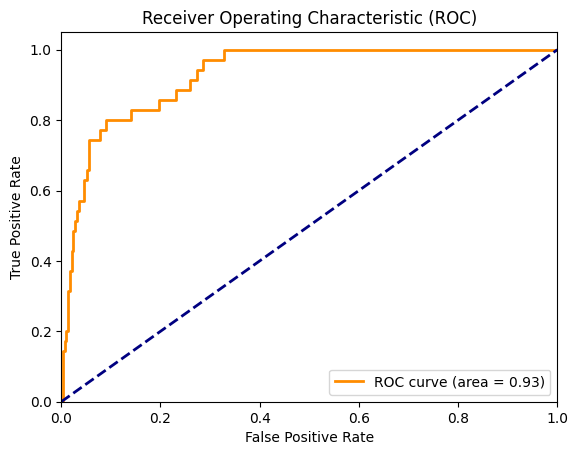

In [9]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Función para imprimir la matriz de confusión
def print_confusion_matrix(confusion_matrix, precision):
  import seaborn as sn
  plt.figure(figsize=(10,7))
  sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion matrix. Prec={}'.format(precision))
  plt.show()

**Fuente del código:** Curso: Fundamentos de Aprendizaje de Máquina - Semana 5 - Taller 5 (Diplomatura de Especialización en Data Analytics - PUCP - 2024)

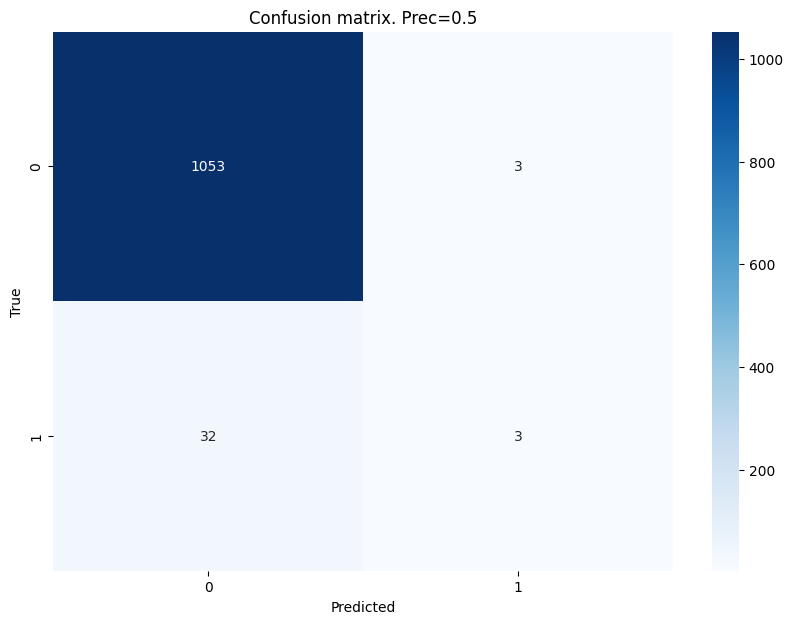

In [11]:
# Matriz de confusión para los datos de validación ajustados
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_precision_lr)

### 2- Árboles de decisión

In [12]:
# Entrenamiento del modelo de árbol de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier()

max_depth = list(range(1,7))
min_samples_split = list(range(2,15))
min_samples_leaf = list(range(1,9))
criterion = ['gini', 'entropy']
max_features = [None, 'sqrt', 'log2']

param_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion,
    'max_features': max_features
}

grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='precision', cv = 5)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14]},
             scoring='precision')

In [13]:
# Mejores parámetros
grid_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 11}

In [14]:
# Mejor modelo
best_dt = grid_dt.best_estimator_
best_dt

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       min_samples_leaf=6, min_samples_split=11)

In [15]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_dt.predict(X_train) 
train_precision = precision_score(y_train, y_pred_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"Precision de entrenamiento: {train_precision:.4f}") 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

Precision de entrenamiento: 0.8891
F1 Score de entrenamiento: 0.9202


In [16]:
# Predicciones en los datos de validación
y_pred_val = best_dt.predict(X_val) 
val_precision_dt = precision_score(y_val, y_pred_val) 
val_f1_dt = f1_score(y_val, y_pred_val) 
print(f"Precision de validacion: {val_precision_dt:.4f}") 
print(f"F1 Score de validacion: {val_f1_dt:.4f}")

Precision de validacion: 0.1656
F1 Score de validacion: 0.2727


In [17]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_dt.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba) 
best_threshold_dt = thresholds[np.argmax(precision[:-1])] 
print(f"Mejor umbral para la precisión: {best_threshold_dt:.4f}")

Mejor umbral para la precisión: 0.9968


In [18]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_dt).astype(int) 
adjusted_precision_dt = precision_score(y_val, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_dt:.4f}")

Precision ajustada: 0.5000


In [19]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_dt = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_dt:.4f}")

AUC Score: 0.9004


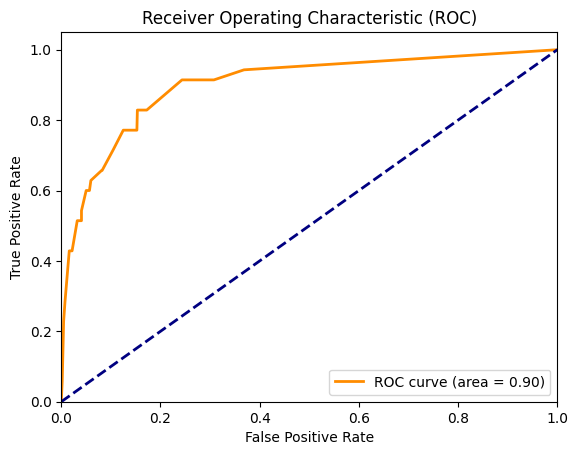

In [20]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

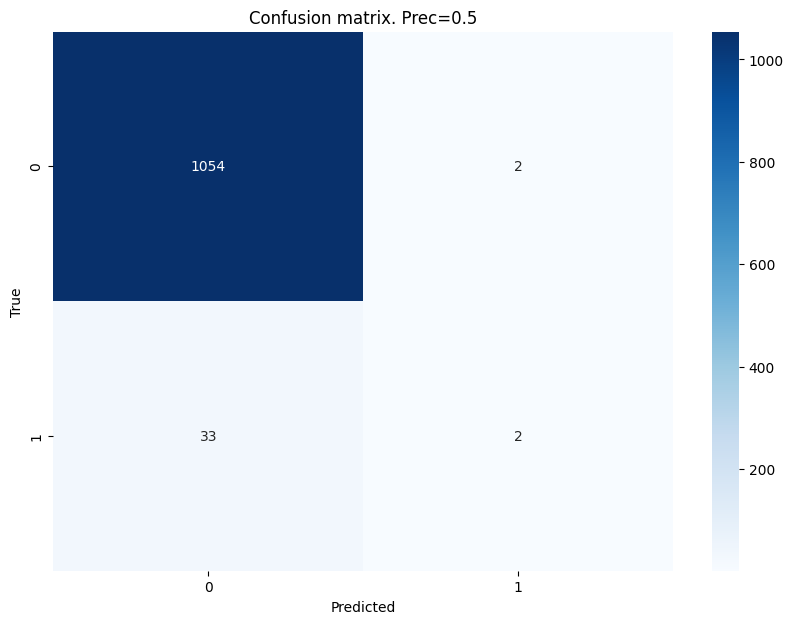

In [21]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_precision_dt)

### 3- Bosque aleatorio

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
n_estimators = [50, 100, 200]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
max_depth = [None, 10, 15, 20]

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features
}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', cv = 5, n_jobs=-1)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring='precision')

In [23]:
# Mejores parámetros
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [24]:
# Mejor modelo
best_rf = grid_rf.best_estimator_
best_rf

RandomForestClassifier(max_depth=15, random_state=42)

In [25]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_rf.predict(X_train) 
train_precision = precision_score(y_train, y_pred_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"Precision de entrenamiento: {train_precision:.4f}") 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

Precision de entrenamiento: 0.9948
F1 Score de entrenamiento: 0.9974


In [26]:
# Predicciones en los datos de validación
y_pred_val = best_rf.predict(X_val) 
val_precision_rf = precision_score(y_val, y_pred_val) 
val_f1_rf = f1_score(y_val, y_pred_val) 
print(f"Precision de validacion: {val_precision_rf:.4f}") 
print(f"F1 Score de validacion: {val_f1_rf:.4f}")

Precision de validacion: 0.2621
F1 Score de validacion: 0.3913


In [27]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_rf.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba) 
best_threshold_rf = thresholds[np.argmax(precision[:-1])] 
print(f"Mejor umbral para la precisión: {best_threshold_rf:.4f}")

Mejor umbral para la precisión: 0.9879


In [28]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_rf).astype(int) 
adjusted_precision_rf = precision_score(y_val, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_rf:.4f}")

Precision ajustada: 1.0000


In [29]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_rf = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_rf:.4f}")

AUC Score: 0.9316


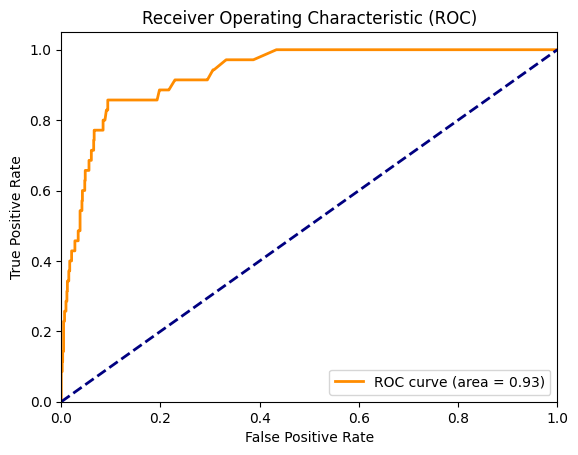

In [30]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

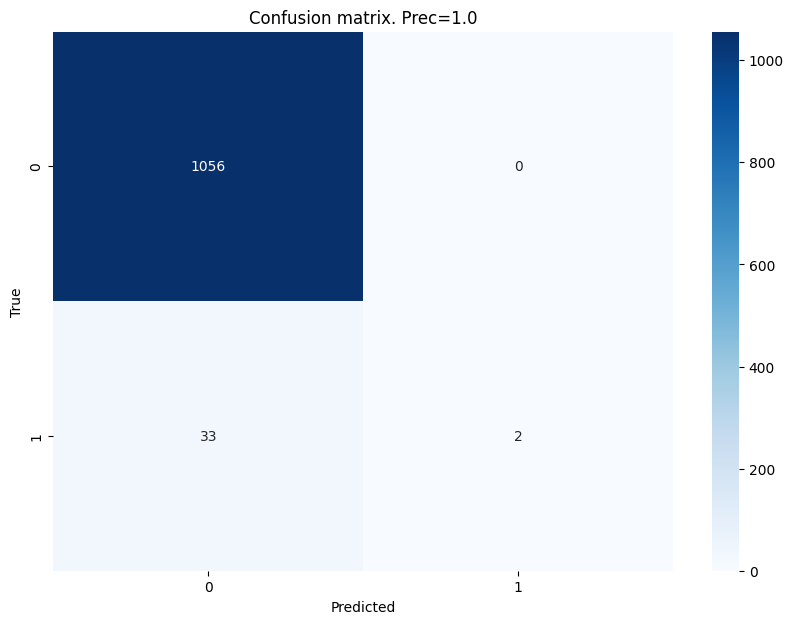

In [31]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_precision_rf)

### 4- Gradient Boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [33]:
# Predicciones en los datos de entrenamiento
y_pred_train = gb_clf.predict(X_train) 
train_precision = precision_score(y_train, y_pred_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"Precision de entrenamiento: {train_precision:.4f}") 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

Precision de entrenamiento: 0.9477
F1 Score de entrenamiento: 0.9668


In [34]:
# Predicciones en los datos de validación
y_pred_val = gb_clf.predict(X_val) 
val_precision_gb = precision_score(y_val, y_pred_val) 
val_f1_gb = f1_score(y_val, y_pred_val) 
print(f"Precision de validacion: {val_precision_gb:.4f}") 
print(f"F1 Score de validacion: {val_f1_gb:.4f}")

Precision de validacion: 0.2222
F1 Score de validacion: 0.3421


In [35]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = gb_clf.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba) 
best_threshold_gb = thresholds[np.argmax(precision[:-1])] 
print(f"Mejor umbral para la precisión: {best_threshold_gb:.4f}")

Mejor umbral para la precisión: 0.9814


In [36]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_gb).astype(int) 
adjusted_precision_gb = precision_score(y_val, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_gb:.4f}")

Precision ajustada: 0.6667


In [37]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_gb = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_gb:.4f}")

AUC Score: 0.9350


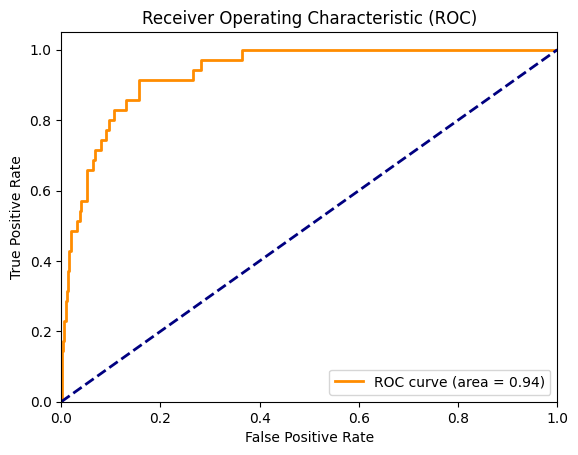

In [38]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

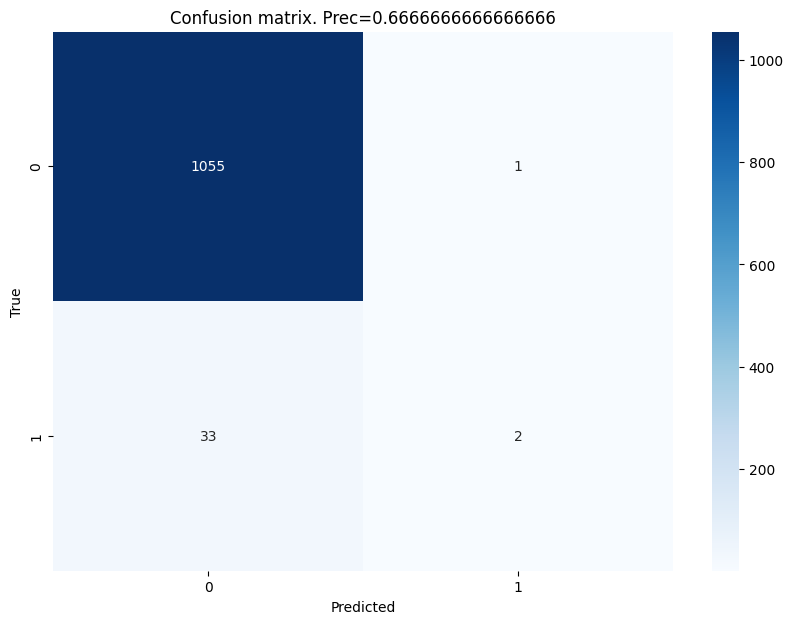

In [39]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_precision_gb)

### 5- KNeighbors Classifier

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}

grid_knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)

grid_knn.fit(X_train, y_train)

c:\Users\herna\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [20, 30, 40], 'n_neighbors': [3, 5, 7, 9],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='precision')

In [41]:
grid_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'distance'}

In [42]:
# Mejor modelo
best_knn = grid_knn.best_estimator_
best_knn

KNeighborsClassifier(leaf_size=20, n_neighbors=9, weights='distance')

In [43]:
# Predicciones en los datos de entrenamiento
y_pred_train = best_knn.predict(X_train) 
train_precision = precision_score(y_train, y_pred_train) 
train_f1 = f1_score(y_train, y_pred_train) 
print(f"Precision de entrenamiento: {train_precision:.4f}") 
print(f"F1 Score de entrenamiento: {train_f1:.4f}")

Precision de entrenamiento: 1.0000
F1 Score de entrenamiento: 0.9770


In [44]:
# Predicciones en los datos de validación
y_pred_val = best_knn.predict(X_val) 
val_precision_knn = precision_score(y_val, y_pred_val) 
val_f1_knn = f1_score(y_val, y_pred_val) 
print(f"Precision de validacion: {val_precision_knn:.4f}") 
print(f"F1 Score de validacion: {val_f1_knn:.4f}")

Precision de validacion: 0.0732
F1 Score de validacion: 0.1250


In [45]:
# Ajuste del umbral en el conjunto de validación
y_pred_proba = best_knn.predict_proba(X_val)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba) 
best_threshold_knn = thresholds[np.argmax(precision[:-1])] 
print(f"Mejor umbral para la precisión: {best_threshold_knn:.4f}")

Mejor umbral para la precisión: 0.4443


In [46]:
# Aplicar el umbral ajustado
y_pred_adjusted = (y_pred_proba > best_threshold_knn).astype(int) 
adjusted_precision_knn = precision_score(y_val, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_knn:.4f}")

Precision ajustada: 0.0700


In [47]:
# Calculo del AUC y curvas ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score_knn = roc_auc_score(y_val, y_pred_proba)
print(f"AUC Score: {auc_score_knn:.4f}")

AUC Score: 0.6375


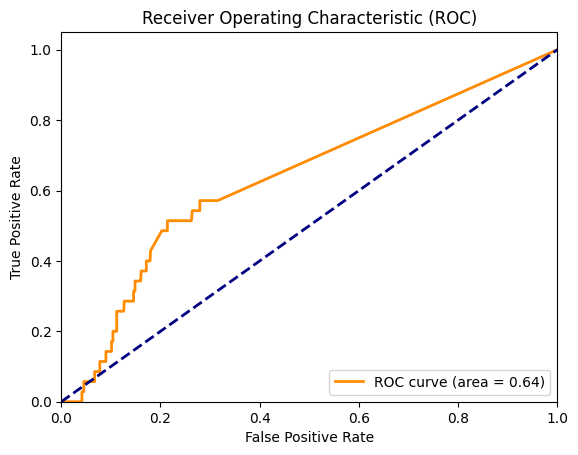

In [48]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

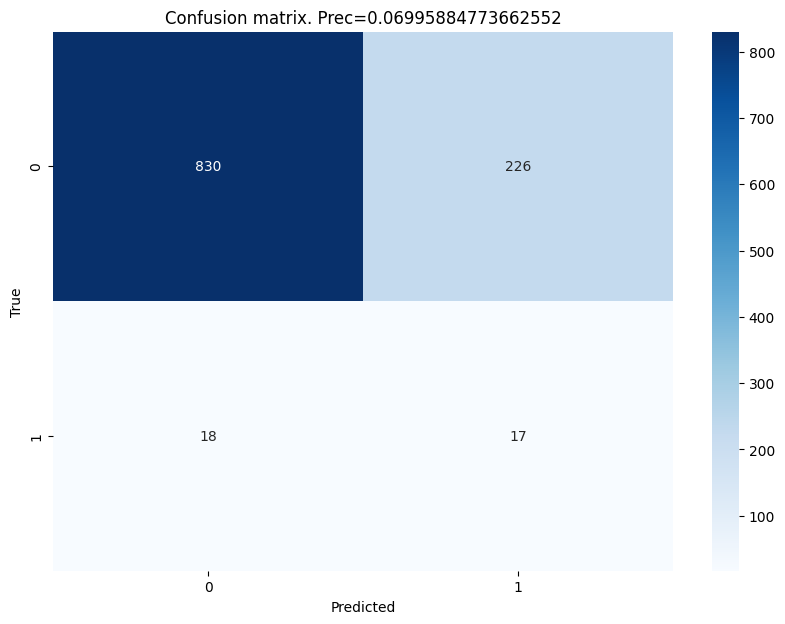

In [49]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_val,y_pred_adjusted), adjusted_precision_knn)

## Comparación de resultados - Validación

In [50]:
modelos = ['Regresion Lineal con Lasso', 'Arbol de decision', 'Bosque aleaotorio', 'Gradient Boosting', 'KNN']
precision = [val_precision_lr, val_precision_dt, val_precision_rf, val_precision_gb, val_precision_knn]
umbrales = [best_threshold_lr, best_threshold_dt, best_threshold_rf, best_threshold_gb, best_threshold_knn]
precision_ajustada = [adjusted_precision_lr, adjusted_precision_dt, adjusted_precision_rf, adjusted_precision_gb, adjusted_precision_knn]
auc = [auc_score_lr, auc_score_dt, auc_score_rf, auc_score_gb, auc_score_knn]

validacion_comparativa = pd.DataFrame({
    'Modelo': modelos,
    'Precisión': precision,
    'Umbral': umbrales,
    'Precisión Ajustada': precision_ajustada,
    'AUC': auc
})

validacion_comparativa


,Modelo,Precisión,Umbral,Precisión Ajustada,AUC
0,Regresion Lineal con Lasso,0.179487,0.998626,0.500000,0.928544
1,Arbol de decision,0.165644,0.996825,0.500000,0.900392
2,Bosque aleaotorio,0.262136,0.987861,1.000000,0.931602
3,Gradient Boosting,0.222222,0.981368,0.666667,0.935038
4,KNN,0.073171,0.444288,0.069959,0.637500


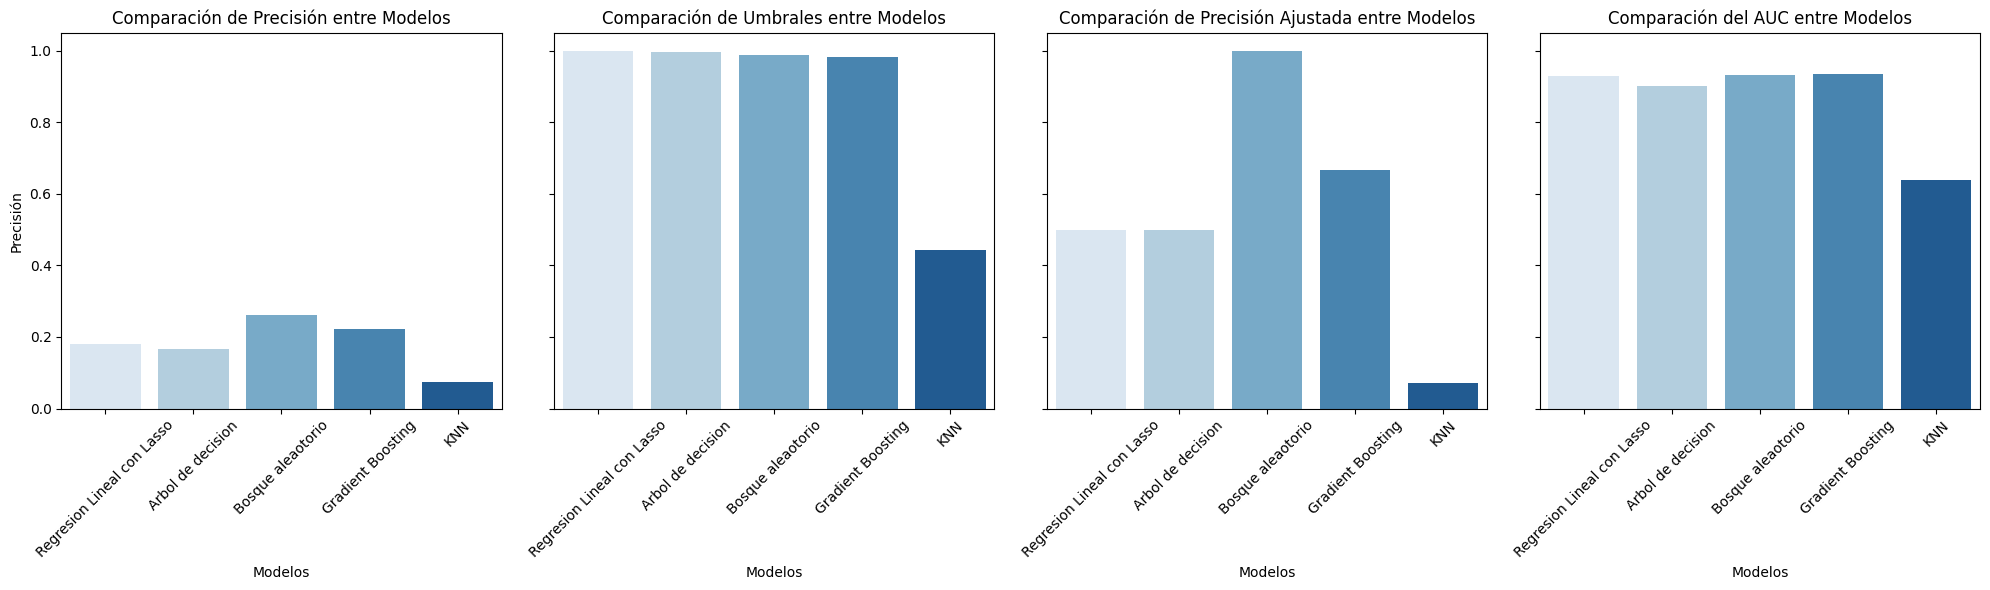

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='Precisión', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[0].set_title('Comparación de Precisión entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Precisión')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de umbrales optimos
sns.barplot(ax=axes[1], x='Modelo', y='Umbral', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[1].set_title('Comparación de Umbrales entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Umbral')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[2], x='Modelo', y='Precisión Ajustada', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[2].set_title('Comparación de Precisión Ajustada entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('Precisión Ajustada')
axes[2].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[3], x='Modelo', y='AUC', hue='Modelo',data=validacion_comparativa, palette='Blues')
axes[3].set_title('Comparación del AUC entre Modelos')
axes[3].set_xlabel('Modelos')
axes[3].set_ylabel('AUC')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Reporte de Resultados - Conjunto de prueba

### 1- Regresión Logística

In [52]:
# Predicciones en los datos de prueba
y_pred_test = clf_lasso.predict(X_test) 
test_precision_lr = precision_score(y_test, y_pred_test) 
test_f1_lr = f1_score(y_test, y_pred_test) 
print(f"Precision de prueba: {test_precision_lr:.4f}") 
print(f"F1 Score de prueba: {test_f1_lr:.4f}")

Precision de prueba: 0.1805
F1 Score de prueba: 0.2972


In [53]:
# Precisión ajustada con el umbral óptimo del conjunto de validación
y_pred_proba = clf_lasso.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_lr).astype(int) 
adjusted_precision_test_lr = precision_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_test_lr:.4f}")

Precision ajustada: 0.8000


In [54]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_lr = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_lr:.4f}")

AUC Score: 0.9247


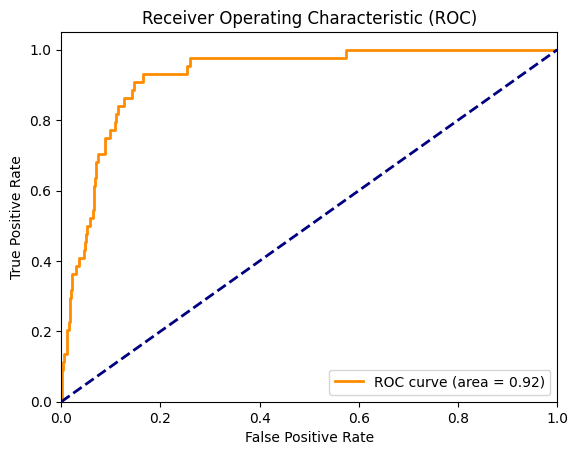

In [55]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

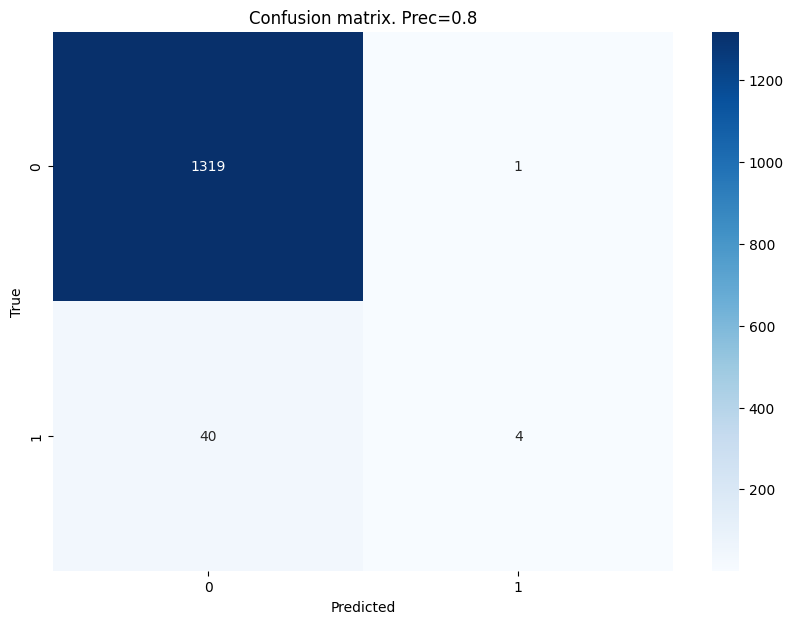

In [56]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_precision_test_lr)

### 2- Árbol de decisión

In [57]:
# Predicciones en los datos de prueba
y_pred_test = best_dt.predict(X_test) 
test_precision_dt = precision_score(y_test, y_pred_test) 
test_f1_dt = f1_score(y_test, y_pred_test) 
print(f"Precision de prueba: {test_precision_dt:.4f}") 
print(f"F1 Score de prueba: {test_f1_dt:.4f}")

Precision de prueba: 0.1674
F1 Score de prueba: 0.2804


In [58]:
# Precisión ajustada con el umbral óptimo del conjunto de validación
y_pred_proba = best_dt.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_dt).astype(int) 
adjusted_precision_test_dt = precision_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_test_dt:.4f}")

Precision ajustada: 0.0000


In [59]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_dt = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_dt:.4f}")

AUC Score: 0.9098


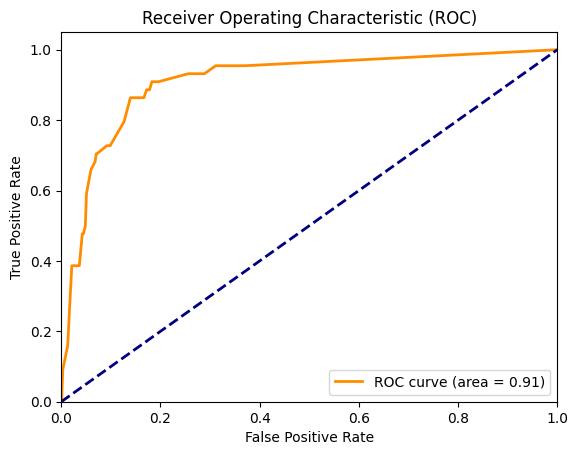

In [60]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

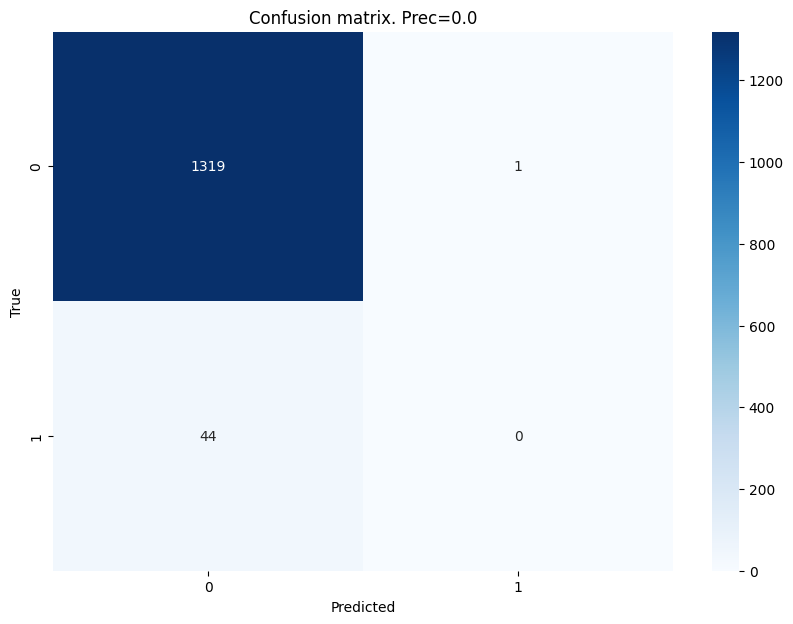

In [61]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_precision_test_dt)

### 3- Bosque aleatorio

In [62]:
# Predicciones en los datos de prueba
y_pred_test = best_rf.predict(X_test) 
test_precision_rf = precision_score(y_test, y_pred_test) 
test_f1_rf = f1_score(y_test, y_pred_test) 
print(f"Precision de prueba: {test_precision_rf:.4f}") 
print(f"F1 Score de prueba: {test_f1_rf:.4f}")

Precision de prueba: 0.2683
F1 Score de prueba: 0.3952


In [63]:
# Precisión ajustada con el umbral óptimo del conjunto de validación
y_pred_proba = best_rf.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_rf).astype(int) 
adjusted_precision_test_rf = precision_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_test_rf:.4f}")

Precision ajustada: 1.0000


In [64]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_rf = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_rf:.4f}")

AUC Score: 0.9399


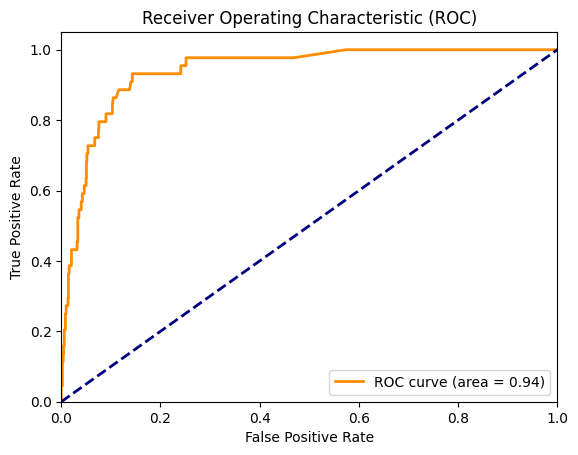

In [65]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

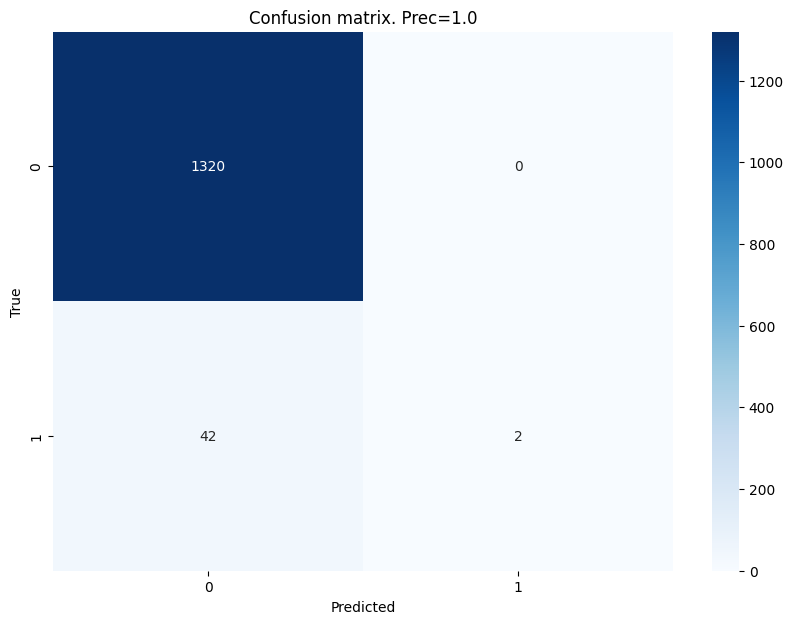

In [66]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_precision_test_rf)

### 4- Gradient Boosting

In [67]:
# Predicciones en los datos de prueba
y_pred_test = gb_clf.predict(X_test) 
test_precision_gb = precision_score(y_test, y_pred_test) 
test_f1_gb = f1_score(y_test, y_pred_test) 
print(f"Precision de prueba: {test_precision_gb:.4f}") 
print(f"F1 Score de prueba: {test_f1_gb:.4f}")

Precision de prueba: 0.2394
F1 Score de prueba: 0.3656


In [68]:
# Precisión ajustada con el umbral óptimo del conjunto de validación
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_gb).astype(int) 
adjusted_precision_test_gb = precision_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_test_gb:.4f}")

Precision ajustada: 0.5000


In [69]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_gb = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_gb:.4f}")

AUC Score: 0.9432


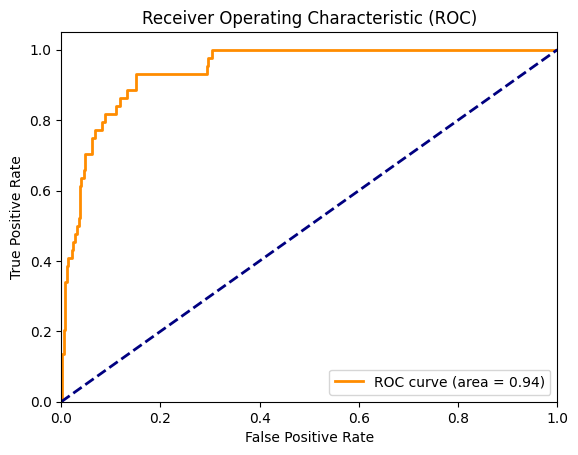

In [70]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

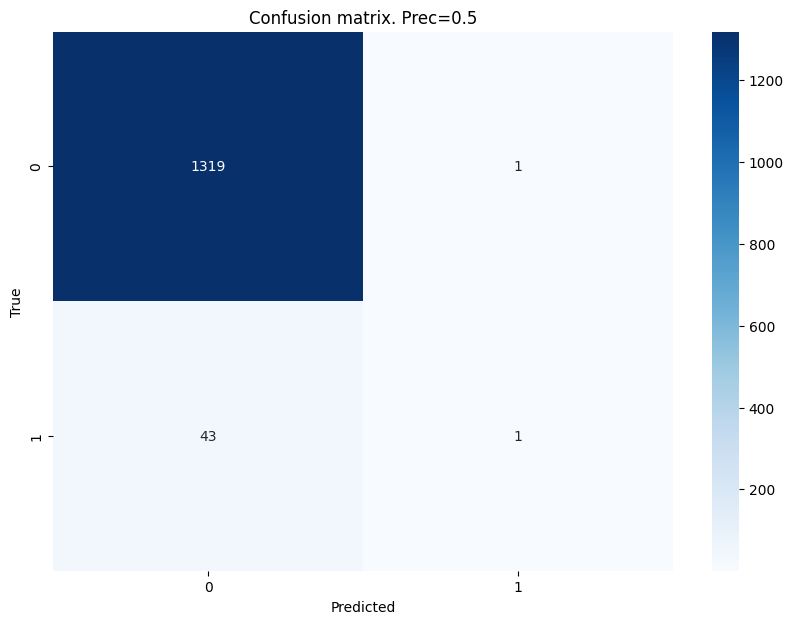

In [71]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_precision_test_gb)

### 5- KNeighbors Classifier

In [72]:
# Predicciones en los datos de prueba
y_pred_test = best_knn.predict(X_test) 
test_precision_knn = precision_score(y_test, y_pred_test) 
test_f1_knn = f1_score(y_test, y_pred_test) 
print(f"Precision de prueba: {test_precision_knn:.4f}") 
print(f"F1 Score de prueba: {test_f1_knn:.4f}")

Precision de prueba: 0.0704
F1 Score de prueba: 0.1220


In [73]:
# Precisión ajustada con el umbral óptimo del conjunto de validación
y_pred_proba = best_knn.predict_proba(X_test)[:, 1] 
y_pred_adjusted = (y_pred_proba > best_threshold_knn).astype(int) 
adjusted_precision_test_knn = precision_score(y_test, y_pred_adjusted) 
print(f"Precision ajustada: {adjusted_precision_test_knn:.4f}")

Precision ajustada: 0.0661


In [74]:
# Calculo del AUC y curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score_test_knn = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score_test_knn:.4f}")

AUC Score: 0.6554


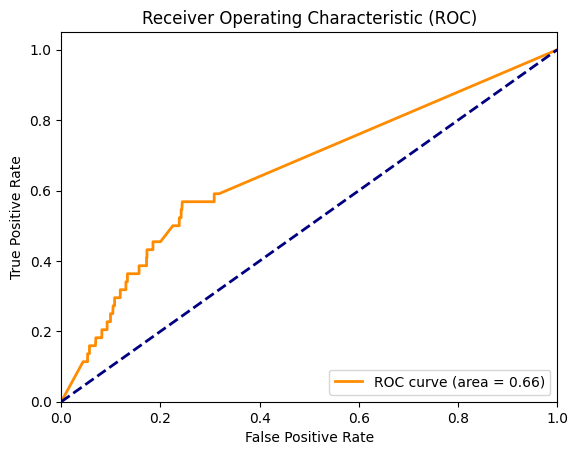

In [75]:
# Gráfica de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_test_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

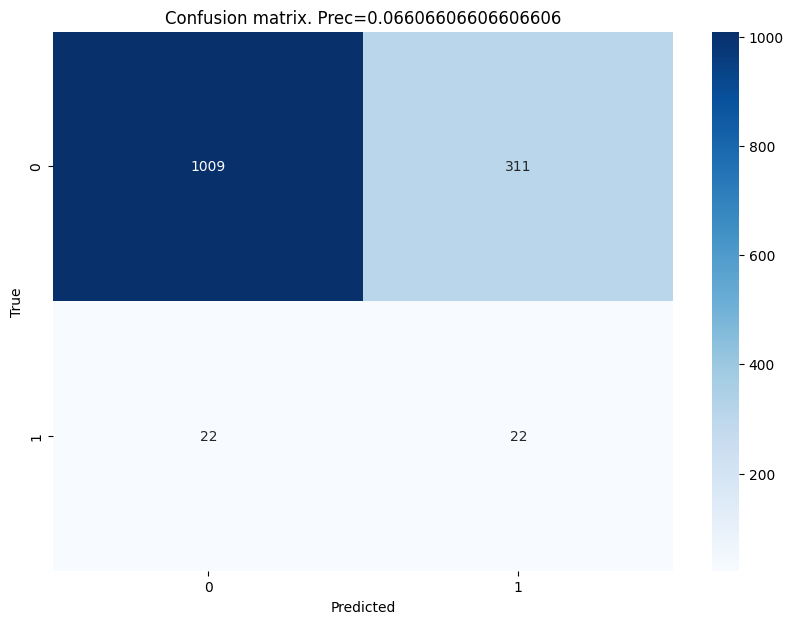

In [76]:
# Matriz de confusión para los datos de validación ajustados
print_confusion_matrix(confusion_matrix(y_test,y_pred_adjusted), adjusted_precision_test_knn)

## Comparación de resultados - Prueba

In [77]:
modelos = ['Regresion Lineal con Lasso', 'Arbol de decision', 'Bosque aleaotorio', 'Gradient Boosting', 'KNN']
precision_test = [test_precision_lr, test_precision_dt, test_precision_rf, test_precision_gb, test_precision_knn]
umbrales = [best_threshold_lr, best_threshold_dt, best_threshold_rf, best_threshold_gb, best_threshold_knn]
precision_ajustada_test = [adjusted_precision_test_lr, adjusted_precision_test_dt, adjusted_precision_test_rf, adjusted_precision_test_gb, adjusted_precision_test_knn]
auc_test = [auc_score_test_lr, auc_score_test_dt, auc_score_test_rf, auc_score_test_gb, auc_score_test_knn]

prueba_comparativa = pd.DataFrame({
    'Modelo': modelos,
    'Precisión': precision_test,
    'Umbral': umbrales,
    'Precisión Ajustada': precision_ajustada_test,
    'AUC': auc_test
})

prueba_comparativa


,Modelo,Precisión,Umbral,Precisión Ajustada,AUC
0,Regresion Lineal con Lasso,0.180488,0.998626,0.800000,0.924673
1,Arbol de decision,0.167401,0.996825,0.000000,0.909797
2,Bosque aleaotorio,0.268293,0.987861,1.000000,0.939885
3,Gradient Boosting,0.239437,0.981368,0.500000,0.943199
4,KNN,0.070423,0.444288,0.066066,0.655381


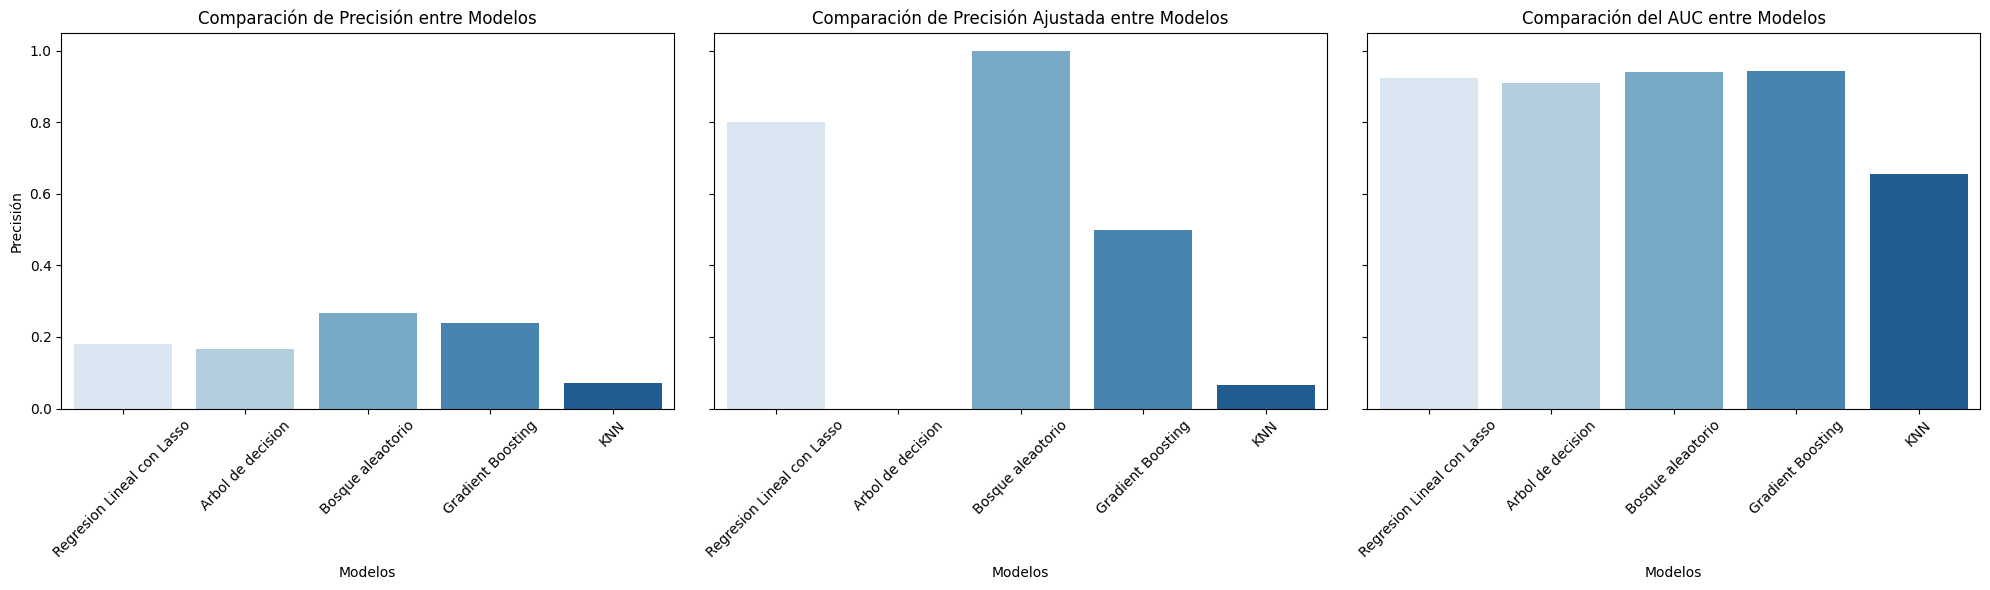

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='Precisión', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[0].set_title('Comparación de Precisión entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Precisión')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[1], x='Modelo', y='Precisión Ajustada', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[1].set_title('Comparación de Precisión Ajustada entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Precisión Ajustada')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[2], x='Modelo', y='AUC', hue='Modelo',data=prueba_comparativa, palette='Blues')
axes[2].set_title('Comparación del AUC entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('AUC')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Comparación: Validación - Prueba

In [79]:
print('En datos de Validación')
print(validacion_comparativa)
print('''
      -----------------------------------------------------------------------------------------------------
      ''')
print('En datos de Prueba')
print(prueba_comparativa)

En datos de Validación
                       Modelo  Precisión    Umbral  Precisión Ajustada  \
0  Regresion Lineal con Lasso   0.179487  0.998626            0.500000   
1           Arbol de decision   0.165644  0.996825            0.500000   
2           Bosque aleaotorio   0.262136  0.987861            1.000000   
3           Gradient Boosting   0.222222  0.981368            0.666667   
4                         KNN   0.073171  0.444288            0.069959   

        AUC  
0  0.928544  
1  0.900392  
2  0.931602  
3  0.935038  
4  0.637500  

      -----------------------------------------------------------------------------------------------------
      
En datos de Prueba
                       Modelo  Precisión    Umbral  Precisión Ajustada  \
0  Regresion Lineal con Lasso   0.180488  0.998626            0.800000   
1           Arbol de decision   0.167401  0.996825            0.000000   
2           Bosque aleaotorio   0.268293  0.987861            1.000000   
3           Gradi

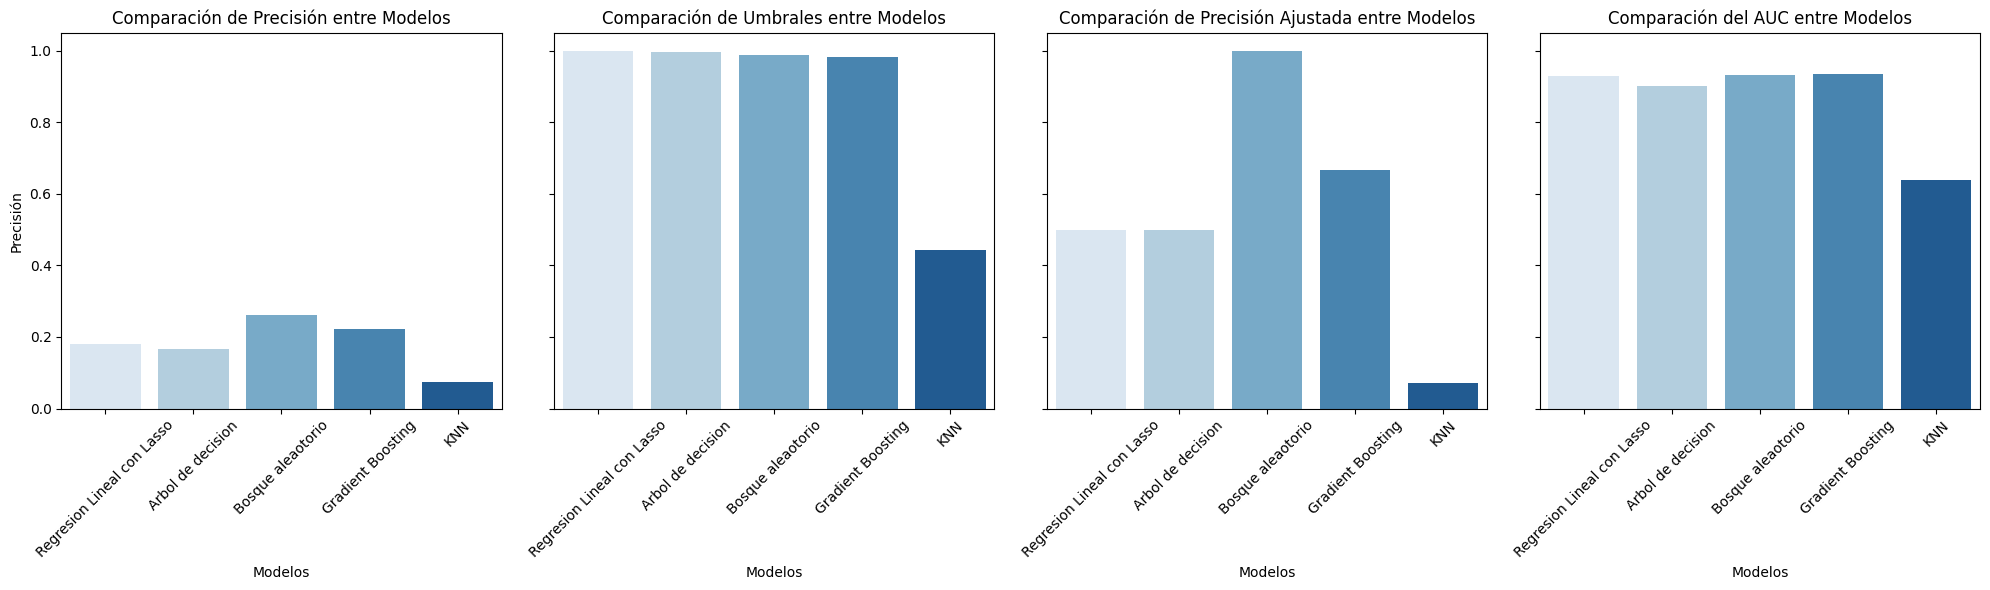

In [80]:
# Datos de Validacion
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='Precisión', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[0].set_title('Comparación de Precisión entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Precisión')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de umbrales optimos
sns.barplot(ax=axes[1], x='Modelo', y='Umbral', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[1].set_title('Comparación de Umbrales entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Umbral')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[2], x='Modelo', y='Precisión Ajustada', hue='Modelo', data=validacion_comparativa, palette='Blues')
axes[2].set_title('Comparación de Precisión Ajustada entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('Precisión Ajustada')
axes[2].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[3], x='Modelo', y='AUC', hue='Modelo',data=validacion_comparativa, palette='Blues')
axes[3].set_title('Comparación del AUC entre Modelos')
axes[3].set_xlabel('Modelos')
axes[3].set_ylabel('AUC')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

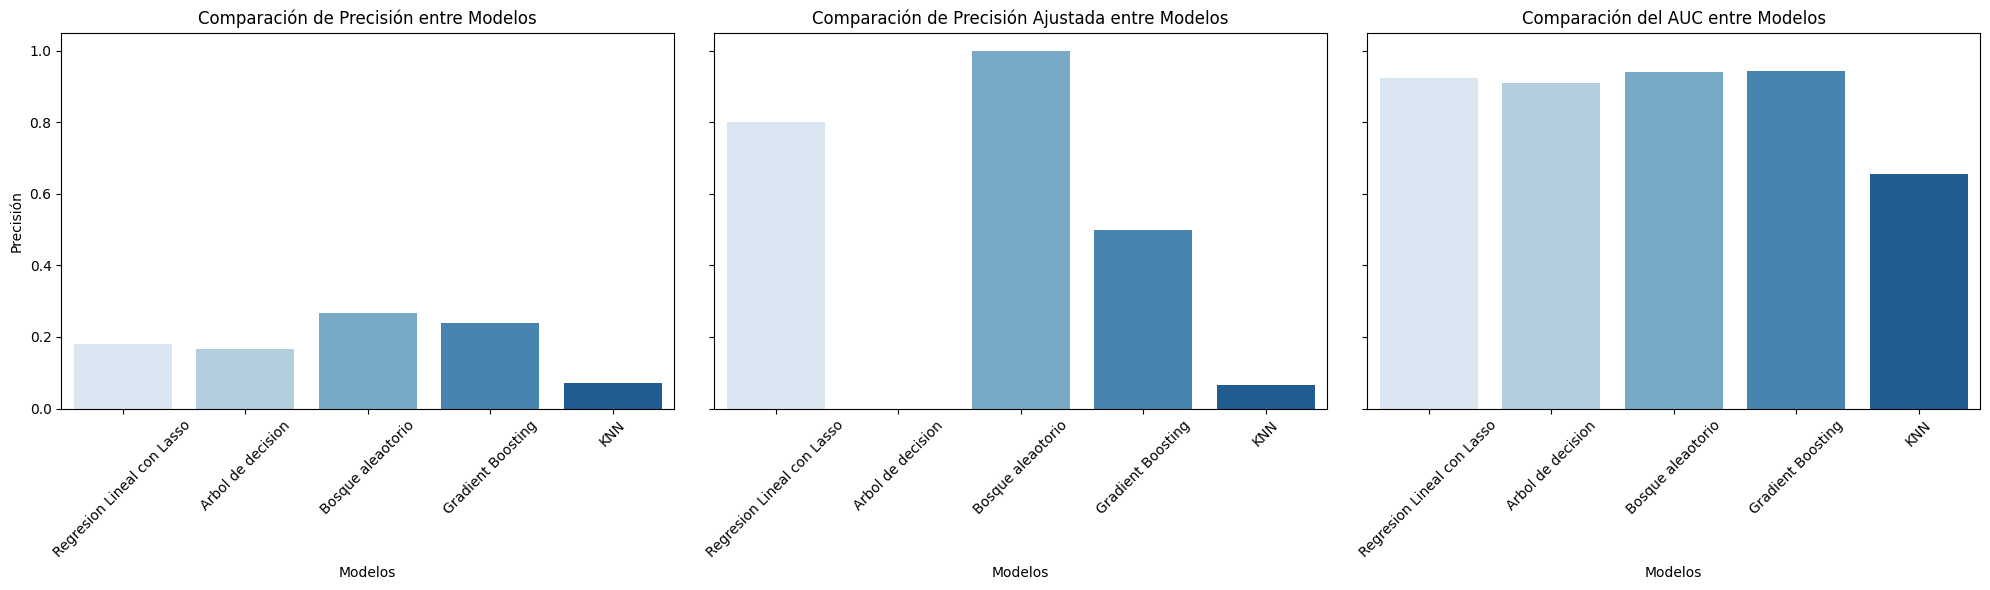

In [81]:
# Datos de Prueba
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Comparacion de la precisión en los datos de validacion
sns.barplot(ax=axes[0], x='Modelo', y='Precisión', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[0].set_title('Comparación de Precisión entre Modelos')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Precisión')
axes[0].tick_params(axis='x', rotation=45)

# Comparacion de la precisión ajustada en los datos validacion
sns.barplot(ax=axes[1], x='Modelo', y='Precisión Ajustada', hue='Modelo', data=prueba_comparativa, palette='Blues')
axes[1].set_title('Comparación de Precisión Ajustada entre Modelos')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Precisión Ajustada')
axes[1].tick_params(axis='x', rotation=45)

# Comparacion del AUC score en los datos de validacion
sns.barplot(ax=axes[2], x='Modelo', y='AUC', hue='Modelo',data=prueba_comparativa, palette='Blues')
axes[2].set_title('Comparación del AUC entre Modelos')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('AUC')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()